# ETL Pipeline (v1.0)

This is a pipeline that uses a CSV file provided by data.gov.sg, an open-source pool of data for our applications. This project focuses on foundational concepts in python like jupyter, pandas and data wrangling of 3 layers:

1. **Raw Layer**: Unprocessed data, fresh from extraction as fast as possible to-be transformed.

2. **Standardized Layer**: Minor processing applied here (data cleaning and formatting) for ease of transformation later.

3. **Enriched layer**: Addition of derived metrics, removal of unneeded ones, grouping of data, etc.

***

## Initialization

Import required modules

In [2]:
from dotenv import load_dotenv
import os, logging
import pandas as pd
import sqlalchemy

Set up display and logging settings

In [3]:
# Setting up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuring panda display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 50)
pd.set_option("display.precision", 2)


Load required environment variables and initialise the connection

In [4]:
# Database connection
load_dotenv()
server="localhost"
pwd = os.getenv("DB_PASSWORD")
uid = os.getenv("DB_USER")

# Create connection string
conn_string = f"postgresql://{uid}:{pwd}@{server}:5432/graduate_employment_survey"
engine = sqlalchemy.create_engine(url=conn_string, pool_pre_ping=True)

Try connecting to the database, otherwise throw an error

In [5]:
try:
    conn = engine.connect()
except sqlalchemy.exc.SQLAlchemyError as e:
    logging.error("Database connection failed: %s", e)
    raise

***

## Extraction

Here we read from a CSV file to extract us a raw dataframe

In [6]:
# Extract data from csv file
def extract(file_path) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
        logging.info("Data extracted successfully from %s", file_path)
        return df
    except FileNotFoundError as e:
        logging.error("File not found: %s", e)
        raise
    except pd.errors.ParserError as e:
        logging.error("Error parsing CSV file: %s", e)
        raise

file_path = "GraduateEmploymentSurveyNTUNUSSITSMUSUSSSUTD.csv"
df = extract(file_path)
print(df)

2024-08-11 21:36:46,888 - INFO - Data extracted successfully from GraduateEmploymentSurveyNTUNUSSITSMUSUSSSUTD.csv


      year                         university  \
0     2013   Nanyang Technological University   
1     2013   Nanyang Technological University   
2     2013   Nanyang Technological University   
3     2013   Nanyang Technological University   
4     2013   Nanyang Technological University   
...    ...                                ...   
1257  2022  Singapore Institute of Technology   
1258  2022  Singapore Institute of Technology   
1259  2022  Singapore Institute of Technology   
1260  2022  Singapore Institute of Technology   
1261  2022  Singapore Institute of Technology   

                                             school  \
0     College of Business (Nanyang Business School)   
1     College of Business (Nanyang Business School)   
2     College of Business (Nanyang Business School)   
3     College of Business (Nanyang Business School)   
4                            College of Engineering   
...                                             ...   
1257                      

## Transformation

From here we perform 2 kinds of transformation on deep copies of dataframes: standardization to clean the raw frame and then enrich it with metrics

In [7]:
def standardize(df: pd.DataFrame) -> pd.DataFrame:
  
    # Keep numeric columns for metadata manipulation
    cols = df.columns.drop(['year', 'university', 'school', 'degree'])
    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

    # Drop degree column for further calculations
    df = df.drop(columns=["degree"])
    
    # Clean the data by removing rows with missing values and rounding to 2 decimal places
    results = df.dropna(axis=0, how="any").round(2)

    logging.info("Data standardized successfully")
    
    return results

df_cleaned = standardize(df.copy(deep=True))
print(df_cleaned)

2024-08-11 21:36:46,916 - INFO - Data standardized successfully


      year                         university  \
0     2013   Nanyang Technological University   
1     2013   Nanyang Technological University   
2     2013   Nanyang Technological University   
3     2013   Nanyang Technological University   
4     2013   Nanyang Technological University   
...    ...                                ...   
1257  2022  Singapore Institute of Technology   
1258  2022  Singapore Institute of Technology   
1259  2022  Singapore Institute of Technology   
1260  2022  Singapore Institute of Technology   
1261  2022  Singapore Institute of Technology   

                                             school  \
0     College of Business (Nanyang Business School)   
1     College of Business (Nanyang Business School)   
2     College of Business (Nanyang Business School)   
3     College of Business (Nanyang Business School)   
4                            College of Engineering   
...                                             ...   
1257                      

This round we perform a simple kind of enrichment where we form groups based on the year, university then school and calculate the mean for each of their numerics rounded to 2 decimal places. Then we add a last updated timestamp too

In [8]:
def enrich(df: pd.DataFrame) -> pd.DataFrame:
    
    # Group the data by university, school and year, and
    # calculate the mean of each group, then add suffix "_mean"
    results = df.groupby(["year", "university", "school"]).mean(numeric_only=True).add_suffix("_mean").reset_index().round(2)
    results["last_updated"] = pd.Timestamp.now()

    logging.info("Data enriched successfully")
    
    return results

df_enriched = enrich(df_cleaned.copy(deep=True))
print(df_enriched)

2024-08-11 21:36:46,936 - INFO - Data enriched successfully


     year  \
0    2013   
1    2013   
2    2013   
3    2013   
4    2013   
..    ...   
340  2022   
341  2022   
342  2022   
343  2022   
344  2022   

                                        university  \
0                 Nanyang Technological University   
1                 Nanyang Technological University   
2                 Nanyang Technological University   
3                 Nanyang Technological University   
4                 Nanyang Technological University   
..                                             ...   
340                Singapore Management University   
341                Singapore Management University   
342        Singapore University of Social Sciences   
343        Singapore University of Social Sciences   
344  Singapore University of Technology and Design   

                                             school  \
0     College of Business (Nanyang Business School)   
1                            College of Engineering   
2     College of Humanities, 

## Loading

Then we load all 3 layers into a local postgres database 

In [9]:
# Load data to a postgres database in 3 layers: raw, standardised, enriched
def load(layer, df: pd.DataFrame):
    table_name = f"{layer}_layer"
    try:
        df.to_sql(table_name, engine, if_exists="replace", index=False)
        logging.info("Data loaded to layer: %s", layer)
    except sqlalchemy.exc.SQLAlchemyError as e:
        logging.error("Failed to load data to %s: %s", layer, e)
        raise

load("raw", df)
load("standardized", df_cleaned)
load("enriched", df_enriched)

2024-08-11 21:36:47,118 - INFO - Data loaded to layer: raw
2024-08-11 21:36:47,196 - INFO - Data loaded to layer: standardized
2024-08-11 21:36:47,231 - INFO - Data loaded to layer: enriched


***

## Visualisation

An additional step for this project is to learn visualisation libraries starting with the OG, matplot library. The figure contains 3 visualizations of the school averages:

1. **Changes in Gross Salary**
2. **Changes in Gross Salary versus Basic Salary**
3. **Changes in employment rates over the years**

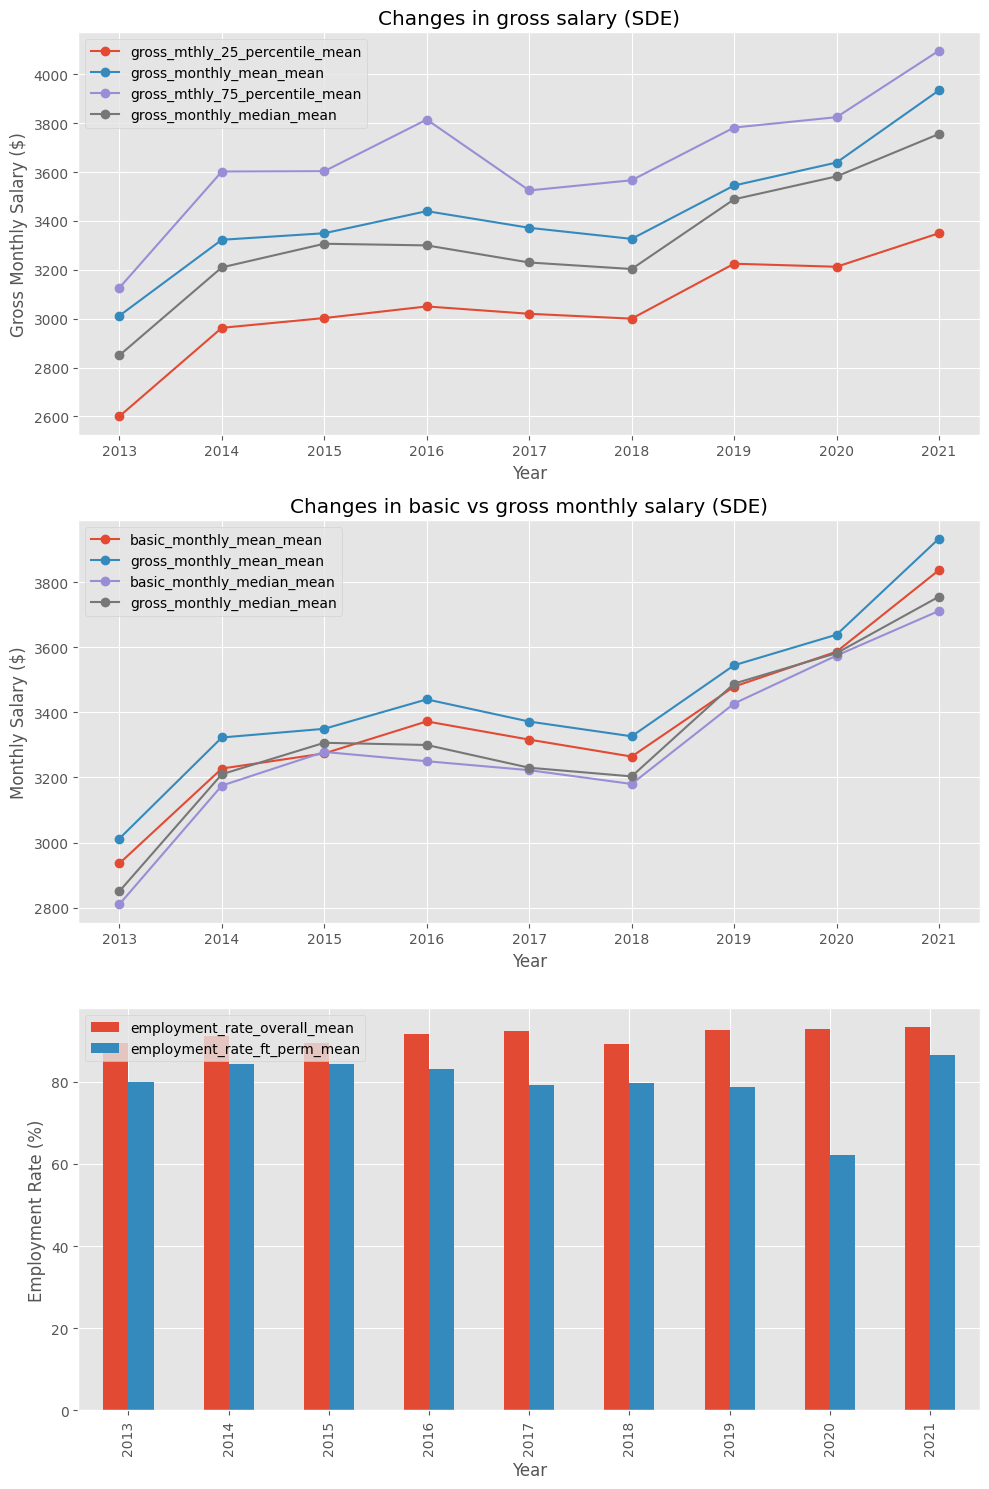

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def visualize_changes_in_overall_employment_rate_in_SDE(df: pd.DataFrame):

    figsize = (10, 15)

    # Filter data for only SDE school
    sde = df[df["school"] == "School of Design & Environment"]
    sde.set_index("year", inplace=True)

    # Create 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)


    # Plot the gross_mthly_25_percentile_mean and gross_mthly_75_percentile_mean with the mean values
    # and the median values
    sde[["gross_mthly_25_percentile_mean", "gross_monthly_mean_mean",
         "gross_mthly_75_percentile_mean",  "gross_monthly_median_mean"]].plot(kind="line", ax=ax1, marker="o")

    ax1.set_xlabel("Year")
    ax1.set_ylabel("Gross Monthly Salary ($)")
    ax1.set_title("Changes in gross salary (SDE)")

    # Plot the basic vs gross monthly salary
    sde[["basic_monthly_mean_mean", "gross_monthly_mean_mean",
         "basic_monthly_median_mean",  "gross_monthly_median_mean"]].plot(kind="line", ax=ax2, marker="o")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Monthly Salary ($)")
    ax2.set_title("Changes in basic vs gross monthly salary (SDE)")
    
    # Plot the overall employment rate
    sde[["employment_rate_overall_mean", "employment_rate_ft_perm_mean"]].plot(kind="bar", ax=ax3) 
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Employment Rate (%)")

    fig.tight_layout()

visualize_changes_in_overall_employment_rate_in_SDE(df_enriched)